<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Nicolás Becerra
- Nombre de alumno 2: Simón Sanfeliú


### **Link de repositorio de GitHub:** https://github.com/SimonSanfeliu/MDS7202-BS/tree/L10

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

## 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Función para transformación logarítmica
def to_log(df_s):
    """
    Aplica una transformación logarítimica a una serie de datos.

    Parameters
    ----------
    df_s : pd.Series
        Serie de datos a transformar.

    Returns
    -------
    pd.Series
        Serie de datos transformada. 
    """
    # Revisando datos
    assert type(df_s) == pd.DataFrame

    # Transformando los datos de la serie a escala logarítmica
    df_s = df_s.apply(lambda x: np.log(x + 1))
    return df_s

In [4]:
# Obteniendo librerías necesarias
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import itertools

# Definiendo la semilla
RANDOM_STATE = 42

# Separando el conjunto de datos
# Obteniendo X
X = df.copy()
X.drop(columns=["Diabetes"], inplace=True)
y = df["Diabetes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=RANDOM_STATE, stratify=y)

# Separando los datos en numéricos y categóricos
num_cols = X_train.corr(numeric_only=True).columns.to_list()
cat_cols = [col for col in X_train.columns if not col in num_cols]

# Atributos numéricos
num_pipe = Pipeline([
                ('Logaritmic scaler', FunctionTransformer(to_log, feature_names_out='one-to-one')),
                ('MinMax scaler', MinMaxScaler())
            ])
# Atributos categóricos
cat_pipe = Pipeline([
    ('Encoder', OneHotEncoder(sparse_output=False))
])

# Creando ColumnTransformer
ctrans = ColumnTransformer(
        transformers=[
            ("Categorico", cat_pipe, cat_cols),
            ("Numerico", num_pipe, num_cols),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
)
ctrans.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('Categorico',
                                 Pipeline(steps=[('Encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 []),
                                ('Numerico',
                                 Pipeline(steps=[('Logaritmic scaler',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function to_log at 0x000001F5BA411E10>)),
                                                 ('MinMax scaler',
                                                  MinMaxScaler())]),
                                 ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI',
                                  'Smoker', 'HeartDiseaseorAttack',
                                  'PhysActivity', 'Fruits', 'Veggies',
                                  'HvyAlcoholConsump', 'GenHlth', 'MentHlth',
                                  'PhysHlth', 'DiffWalk', 'Stroke',
                                  'HighBP'])],
                  verbose_feature_names_out=False)

              precision    recall  f1-score   support

           0       0.70      0.77      0.74     10671
           1       0.79      0.73      0.76     12658

    accuracy                           0.75     23329
   macro avg       0.75      0.75      0.75     23329
weighted avg       0.75      0.75      0.75     23329



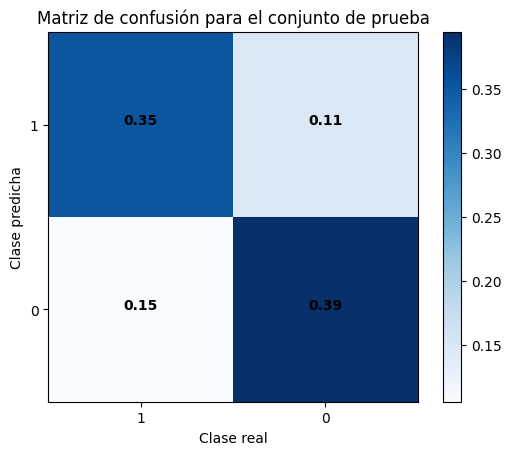

In [5]:
import xgboost as xgb

# Pipeline de entrenamiento
pipe_train = Pipeline([
    ("Scaling", ctrans),
    ("Classifier", xgb.XGBClassifier(objective='binary:logistic'))
])

# Entrenando
model = pipe_train.fit(X_train, y_train)

# Prediciendo en prueba
y_pred_test = model.predict(X_test)

# Reporte de clasificación y matriz de confusión
print(classification_report(y_pred_test, y_test))
conf_mat2 = confusion_matrix(y_test, y_pred_test, normalize='all')
plt.imshow(conf_mat2, cmap=plt.cm.Blues)
plt.xticks([1,0], [0,1])
plt.yticks([1,0], [0,1])
plt.title("Matriz de confusión para el conjunto de prueba")
plt.xlabel("Clase real")
plt.ylabel("Clase predicha")
plt.colorbar()
for i,j in itertools.product(range(conf_mat2.shape[0]), range(conf_mat2.shape[1])):
    plt.text(i,j,round(conf_mat2[i,j], 2), horizontalalignment="center", color="black", weight="bold")

> Para el pipeline mostrado aquí, se decidió tomar un clasificador XGBoost para poder hacer de forma correcta la clasificación binaria pedida, especificando este tipo de clasificación en sus parámetros. Se decidió seguir el mismo pipeline del laboratorio anterior, teniendo un OneHotEncoder para las variables no numéricas y aplicando una transformación logarítmica junto con un MixMaxScaler para las numéricas, debido a la eficacia de éste y de los buenos resultados que ha entregado en laboratorios anteriores. Sin embargo, dada la gran cantidad de columnas numéricas con valores pequeños, podría ser innecesario un preprocesamiento de estos datos tan exhaustivo, pero por convención y eficiencia se deja de todos modos.

> Respecto a los resultados obtenidos, se probaron distintas configuraciones de parámetros en el clasificador. Finalmente se prefirió dejar los valores por defecto y se pudo ver un accuracy en el F1 Score de 0.75. Esto implicaría que el clasificador es es apropiado para predecir la diabetes en los pacientes, pero que puede mejorar su rendimiento.

> La *precision* muestra cuántas predicciones correctas se hicieron de una clase dividido en cuántas predicciones de esa clase se hicieron. Mientras más alto el valor, mejor, teniendo que se tienen precisiones de 0.70 para la clase 0 (no diabetes) y 0.79 para la clase 1 (diabetes). Esto daría cuenta de que se predice mejor el que se tenga diabetes a predecir que no lo tiene (hay muchos falsos positivos en el caso de no tener diabetes).

> El *recall* es cuántas predicciones correctas se hicieron de una clase dividido en cuántos valores reales de ésta hay en el dataset. Mientras más alto, mejor, teniendo que el *recall* fue 0.77 para la clase 0 y 0.73 para la clase 1. Esto quiere decir que, mientras que dentro de sus propias predicciones, la clase 1 es mejor predicha, en el set de datos global, se predice mejor la clase 0 (hay más falsos negativos de la clase 0).

> Finalmente, el F1 Score combina las dos métricas anteriores, teniendo en consideración ambos *trade-offs*. De esta forma, es una métrica muy global para definir la eficiencia de los modelos, de ahí que se vea que la clase 1 tiene en ambos conjuntos un valor de 0.76 y la 0 de 0.74, indicando una mayor eficiencia del modelo a la hora de predecir que una persona tiene efectivamente diabetes; puesto que mientras más ceracana al 1 esta métrica, mejor será el modelo.

> Tomando esto en consideración es que se usa el F1 Score para medir el rendimiento, notando que el *accuracy* total de los conjuntos en el F1 Score es de 0.75, lo que indica un gran rendimiento, pero que aún puede mejorarse, ya que usualmente un modelo con *accuracy* (de todas las predicciones, cuántas fueron correctas) sobre 0.7 es decente, pero no perfecto. Asimismo, las otras métricas brindadas permiten dar cuenta de los buenos resultados que da el modelo, teniendo a todas sobre 0.7 y cercanas al 1 (la perfección), denotando la eficiencia de éste y pudiendo entrever su eficiencia por clase.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

Text(0.5, 1.0, "Feature Importance con importance_type='weight'")

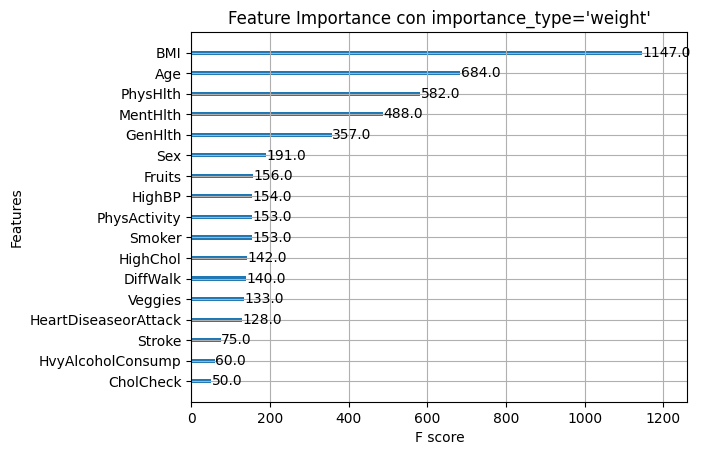

In [6]:
# Obteniendo el gráfico de importancia de los features para distintos tipos de cálculo de importancia
from xgboost import plot_importance
# Método weight
plot_importance(model["Classifier"], importance_type="weight")
plt.title("Feature Importance con importance_type='weight'")

Text(0.5, 1.0, "Feature Importance con importance_type='cover'")

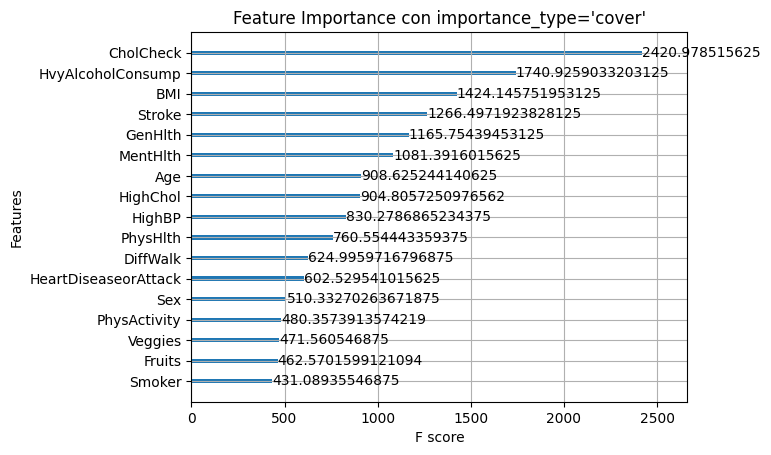

In [7]:
# Método cover
plot_importance(model["Classifier"], importance_type="cover")
plt.title("Feature Importance con importance_type='cover'")

Text(0.5, 1.0, "Feature Importance con importance_type='gain'")

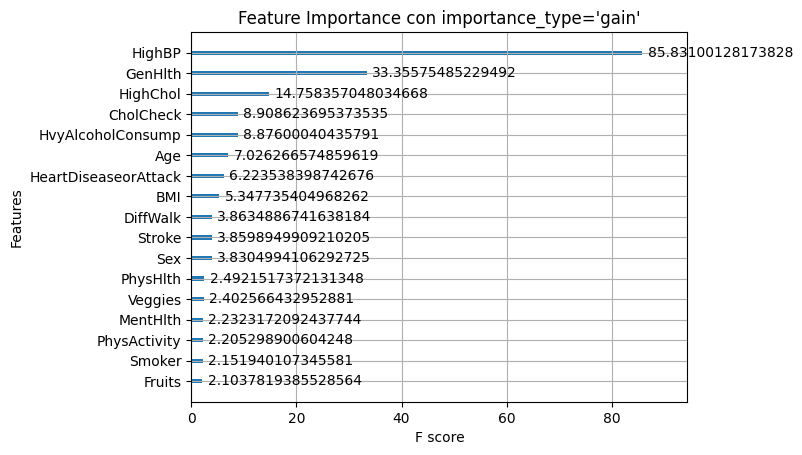

In [8]:
# Método gain
plot_importance(model["Classifier"], importance_type="gain")
plt.title("Feature Importance con importance_type='gain'")

> Los resultados obtenidos son compatibles en el sentido de que todos se calculan en función del número de veces que se utiliza una característica para dividir un nodo en un árbol de decisión (el caso de XGBoost). La diferencia radica en cómo se calcula este número, lo que lleva a que las importancias vayan rotando. Esto implica que los distintos métodos permiten ver distintas maneras de cómo se está dividiendo el árbol de decisión. Por ejemplo, *weight* define la importancia por la cantidad de veces que el feature aparece en un árbol, *cover* es la cantidad promedio de splits que cubre (número de muestras afectadas por el split) la característica y *gain* es la ganancia promedio de splits que usan dicha característica. Así, se puede ver que los 3 métodos entregan distintas formas de ver la importancia de los features que son compatibles entre sí.

> Dado esto, es posible ver distintos niveles de importancia en cada uno de los gráficos, variando el nivel de cada característica. En general, los resultados de *weight* y *cover* son similares, teniendo a BMI, GenHlth, MentHlth y Age entre las características más importantes, pero estas varían mucho más en *gain*. Estas diferencias son esperables por cómo se calculan las importancias, viendo que el método *weight* es similar al de *cover*.

> Para finalizar, las importancias obtenidas sólo permiten ver la importancia de la característica para la precisión global del modelo, además de que ciertas variables tienen muchos valores posibles, lo que llevaría a que siempre estas características sean importantes por el simple hecho de que hay más formas de dividirlas. De esta forma, mientras que ayudan a entender la importancia de los features para un modelo de árboles, no pueden permiten encontrar la interpretabilidad completa del modelo, dada la sensibilidad de estos métodos ante valores variados dentro de las características.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [9]:
# Aplicando el método de permutación
from sklearn.inspection import permutation_importance
result = permutation_importance(model["Classifier"], X_test, y_test, n_repeats=30, random_state=RANDOM_STATE)
print(f"Desviaciones estándar de la importancia: {result['importances_std']}")

Desviaciones estándar de la importancia: [0.         0.00080672 0.00072748 0.00056938 0.         0.00113714
 0.00077104 0.00090354 0.00128816 0.00089503 0.00044349 0.
 0.00127041 0.00148629 0.00075542 0.00055625 0.00162949]


Text(0.5, 0, 'Error')

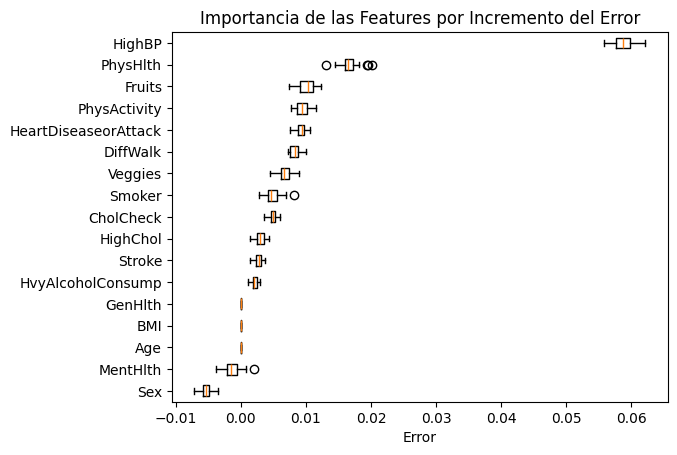

In [10]:
# Graficando los resultados anteriores
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(X_test.columns)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')

> Las desviaciones estándar señalan cuánto varía la importancia de cada feature.

> La propuesta mide la importancia como la resta entre el error basado en las predicciones del conjunto de datos permutado y el error basado en las predicciones del conjunto original (sin permutar).

> Las 5 características que tuvieron un mayor impacto en la salida del modelo fueron HighBP (presión alta), PhysHlth (salud física), Fruits (consumo regular de frutas), PhysActivity (realiza actividad física) y HeartDiseaseorAttack (historial de enfermedades cardíacas o paros cardíacos). Es razonable que estas sean las más importantes para definir si un paciente tiene o no diabetes, sobre todo la tipo 2, ya que permitiría definir los hábitos del paciente que llevarían a evitar que éste contrayera la condición. Asimismo, estas características permiten, valga la redundanica, caracterizar a la personas diabéticas, puesto que para aquellas que tengan tipo 1 tendrán éstas bastante afectadas ya.

> Las features aquí enlistadas tienen mucho más sentido que las vistas en los otros gráficos, puesto que destacan síntomas específicos de personas que padecen de diabetes por sobre características generales de las personas. Asimismo, se puede ver que distintas features que antes eran muy importantes (como BMI y Age), resulta ser que tienen una desviación en su importancia de 0, por lo que son igual de no importantes para todo el dataset. Son intransigentes, por lo que este método permite tener una visión global mucho más completa.

> Ventajas:
> - Fácil interpretación: Permite ver gráfica y numéricamente cuáles features son las más importantes.
> - Alta compresión de interpretabilidad global: permite ver de forma concisa el desempeño global de cada característica, como se mencionó anteriormente. Así, es más sencillo y más general el llevar a cabo la interpretación.
> - No necesita re-entrenar el modelo: Se le puede entregar un modelo entrenado y evaluar éste directamente en el conjunto de prueba, disminuyendo así los tiempos de ejecución considerablemente para poder interpretar.

> Desventajas:
> - Enlazado al error del modelo: Como la importancia se calcula en base al error, si se tiene un modelo deficiente, las importancias calculadas serán en base a la deficiencia de éste, lo que no permitiría una buena interpretación.
> - Si las features están correlacionadas puede generar sesgos por entradas poco realistas: Al tener características correlacionadas, la permutación no llevará a tener muchos cambios en el error, lo que llevaría a tener sesgos en la importancia de estos features.
> - Añadir una feature correlacionada puede decrecer la importancia de una feature asociada al separar la importancia en las dos features: Precisamente por lo comentado anteriormente, como el error no variará tanto, esto llevará a que estas características tengan una menor importancia (menor diferencia de errores).

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [11]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [12]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [13]:
# Calculando los shap values teniendo en cuenta que boosting son árboles
import shap

# Calculando los valores
explainer = shap.TreeExplainer(model["Classifier"])
shap_values = explainer(X)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[00:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [14]:
# Viendo los valores
shap_values

.values =
array([[ 0.158132  , -0.10326613, -0.40514246, ..., -0.10215715,
        -0.01333452,  0.5722986 ],
       [ 0.28572232, -0.24236968,  0.24049461, ..., -0.07376755,
         0.19350985,  0.5522304 ],
       [ 0.22512576, -0.00592881, -0.27613813, ..., -0.11459348,
        -0.03089161, -0.6499026 ],
       ...,
       [ 0.03109661,  0.12961714,  0.21607704, ..., -0.01302011,
        -0.02686371,  0.517731  ],
       [ 0.03976111,  0.06480618,  0.17090622, ..., -0.0467571 ,
        -0.03218078,  0.4992999 ],
       [-0.19199596,  0.11557759,  0.27337304, ..., -0.07578182,
        -0.03370389,  0.38997793]], dtype=float32)

.base_values =
array([-0.00817224, -0.00817224, -0.00817224, ..., -0.00817224,
       -0.00817224, -0.00817224], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.

In [15]:
# Instancia de ejemplo
shap_values.values[1,:]

array([ 0.28572232, -0.24236968,  0.24049461,  0.01405665,  0.1921069 ,
       -0.08493321, -0.07776659,  0.11883271, -0.05053177,  0.10707276,
        0.02110081,  0.68238205,  0.01911099, -0.10405093, -0.07376755,
        0.19350985,  0.5522304 ], dtype=float32)

> Los base_values corresponden al valor esperado de la predicción si no tuviera información sobre las features. Se utiliza como punto de referencia para calcular los shap values. Los shap values corresponden a la contribución de cada feature para la predicción del modelo. Si el valor es positivo, la feature contribuye a aumentar la predicción, mientras que si es negativo, contribuye a disminuirla.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [16]:
# Graficando los shap_values por variable
idx = 1

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

In [17]:
idx = 9

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

In [18]:
idx = 150

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values.values[idx,:], 
                X.iloc[idx,:],
                link="logit")

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

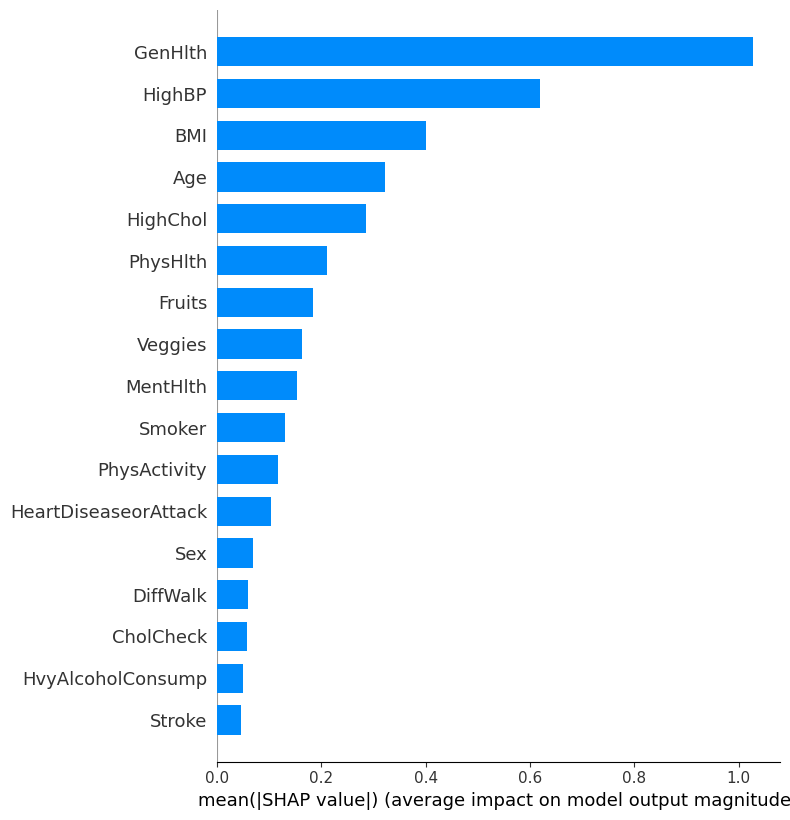

In [19]:
# Aporte global
shap.summary_plot(shap_values, X, plot_type="bar")

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

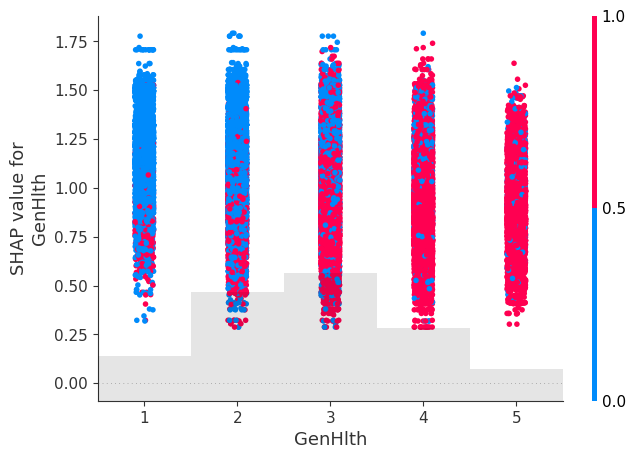

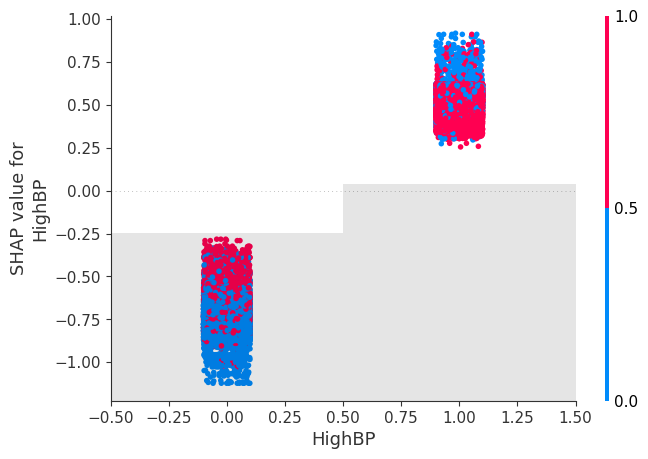

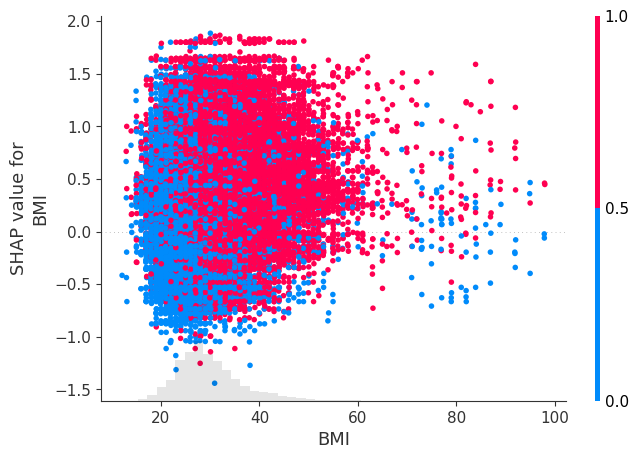

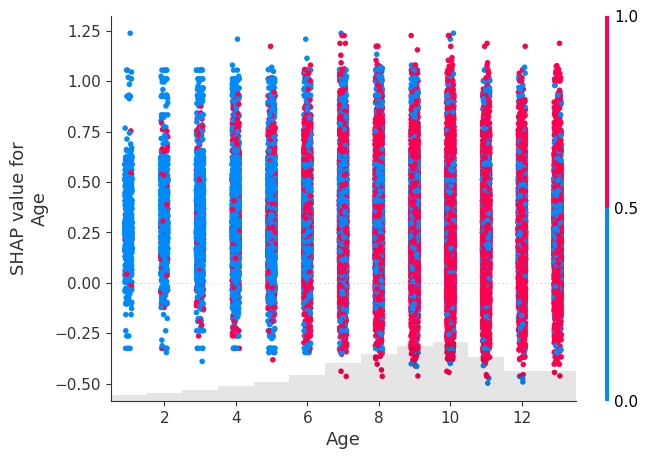

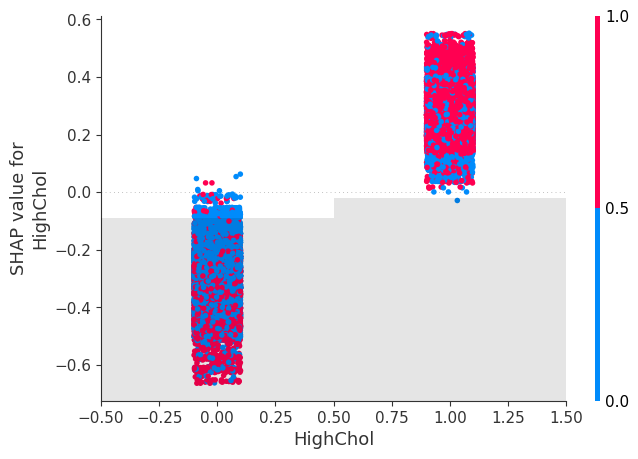

In [20]:
# Obteniendo los features en orden de importancia
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

# Obteniendo predicciones sobre todo el conjunto (igual que los SHAP values)
y = model.predict(X)

# Graficando los 5 primeros features
for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:,name], 
                   color=y)

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

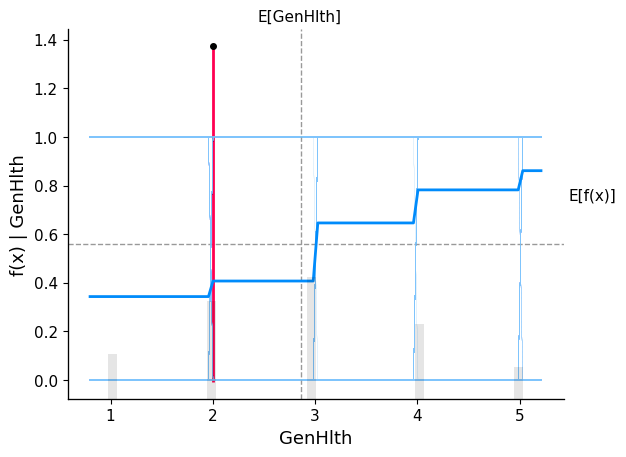

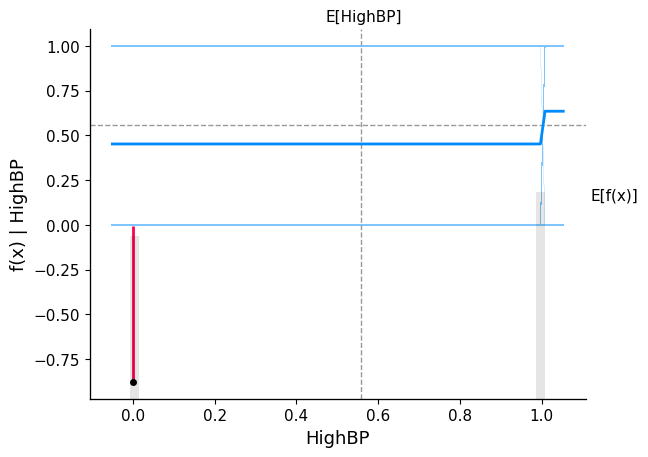

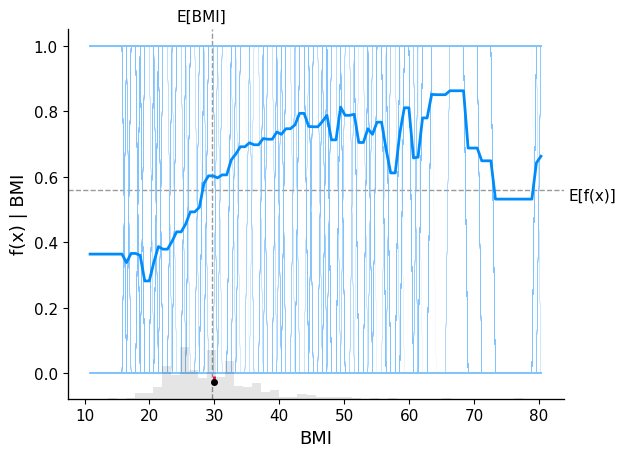

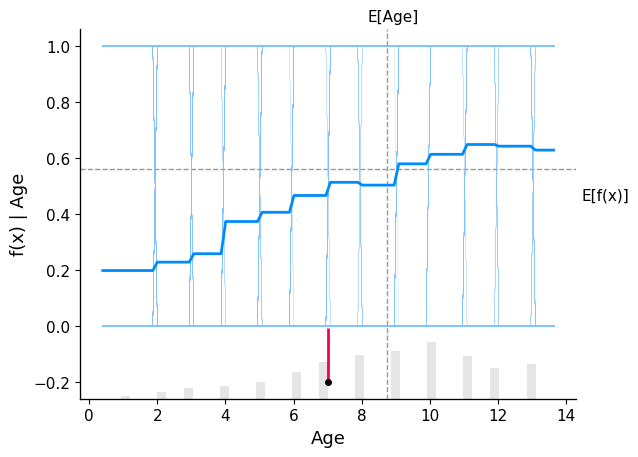

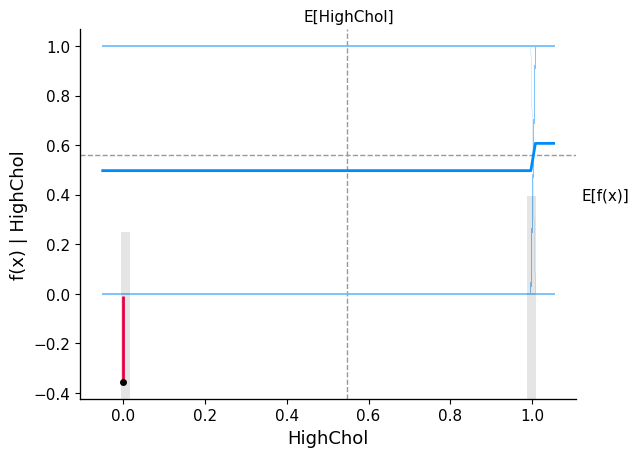

In [21]:
# Obteniendo gráfico PDP
X1000 = shap.utils.sample(X, 1000)

sample_ind = 200
# Graficando los 5 primeros features
for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
        name, model.predict, X1000, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind:sample_ind+1,:]
    )

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [22]:
!pip install alibi

Defaulting to user installation because normal site-packages is not writeable


In [27]:
# Aplicando las reglas
from alibi.explainers import AnchorTabular

predict_fn = lambda x: model["Classifier"].predict(x)
explainer = AnchorTabular(predict_fn, model["Classifier"].feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [29]:
idx = 1000
# explicar predicción idx 1000

explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: Fruits <= 0.00 AND MentHlth <= 0.00
Precision: 0.99
Coverage: 0.26


In [30]:
idx = 3001
# explicar predicción idx 3001

explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Anchor: Sex <= 0.00 AND BMI > 33.00 AND HighBP <= 1.00 AND HvyAlcoholConsump <= 0.00 AND DiffWalk <= 1.00 AND Smoker <= 1.00 AND Veggies <= 1.00 AND PhysActivity <= 1.00 AND HighChol <= 1.00
Precision: 0.93
Coverage: 0.14


In [31]:
idx = 5751
# explicar predicción idx 5751

explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: HighBP > 0.00
Precision: 0.99
Coverage: 0.56


# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>